In [1]:
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml

In [2]:
geo_file = "./data/h2.xyz"

symbols, coordinates = qml.qchem.read_structure(geo_file)
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

print("Number of qubits = ", qubits)

Number of qubits =  4


In [3]:
dev = qml.device("default.qubit", wires=qubits)
hf_state = np.array([1, 1, 0, 0], requires_grad=False)

def ansatz(params, wires=[0, 1, 2, 3]):
    qml.BasisState(hf_state, wires=wires)
    for i in wires:
        qml.RZ(params[3 * i], wires=i)
        qml.RY(params[3 * i + 1], wires=i)
        qml.RZ(params[3 * i + 2], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])

In [4]:
@qml.qnode(dev)
def cost(params):
    ansatz(params)
    return qml.expval(hamiltonian)

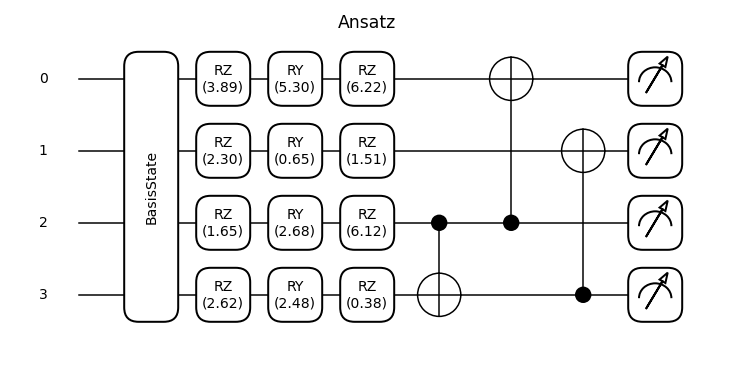

In [5]:
init_params = np.random.uniform(low=0, high=2 * np.pi, size=12)

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(cost, decimals=2)(init_params)
fig1.suptitle("Ansatz", fontsize='xx-large')
plt.savefig('HM.png')
plt.show()

In [6]:
exact_value = -1.136189454088
np.random.seed(0)
init_params = np.random.uniform(low=0, high=2 * np.pi, size=12, requires_grad=True)
max_iterations = 100
step_size = 0.5
conv_tol = 1e-06

## SGD Optimizer

In [7]:
opt = qml.GradientDescentOptimizer(step_size)

params = init_params

sgd_cost = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost, params)
    sgd_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

#     if conv <= conv_tol:
#         break


print()
print("Final convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = -0.09424332 Ha
Iteration = 20,  Energy = -0.55156842 Ha
Iteration = 40,  Energy = -1.12731586 Ha
Iteration = 60,  Energy = -1.13583263 Ha
Iteration = 80,  Energy = -1.13602366 Ha

Final convergence parameter = 0.00000311 Ha
Number of iterations =  99
Final value of the ground-state energy = -1.13610796 Ha
Accuracy with respect to the FCI energy: 0.00008150 Ha (0.05114034 kcal/mol)

Final circuit parameters = 
 [3.44829694e+00 6.28318517e+00 3.78727399e+00 3.42360201e+00
 9.85707006e-06 4.05827240e+00 2.74944154e+00 6.07393829e+00
 6.21700547e+00 2.40923412e+00 6.28318528e+00 3.32314479e+00]


## Quantum Natural Gradient

In [8]:
opt = qml.QNGOptimizer(0.5, lam=0.001, approx="block-diag")

params = init_params
prev_energy = cost(params)
qngd_cost = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost, params)
    qngd_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

#     if conv <= conv_tol:
#         break


print("\nFinal convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = -0.32164518 Ha
Iteration = 20,  Energy = -1.13618945 Ha
Iteration = 40,  Energy = -1.13618945 Ha
Iteration = 60,  Energy = -1.13618945 Ha
Iteration = 80,  Energy = -1.13618945 Ha

Final convergence parameter = 0.00000000 Ha
Number of iterations =  99
Final value of the ground-state energy = -1.13618945 Ha
Accuracy with respect to the FCI energy: 0.00000000 Ha (0.00000001 kcal/mol)

Final circuit parameters = 
 [3.44829694e+00 6.28318531e+00 3.78727399e+00 3.42360201e+00
 8.26474811e-39 4.05827240e+00 2.74944154e+00 6.07345073e+00
 6.28318531e+00 2.40923412e+00 6.28318531e+00 3.32314479e+00]


## Look Around Warm-start Natural Gradient Descent

In [9]:
from pennylane.optimize.momentum import MomentumOptimizer
from laws_ngd import LAWSNG

gradient_method = "default"
#gradient_method = "ema"
# opt = LAWSNG(delta= 0.01,
#              lookaround_optimizer=MomentumOptimizer, 
#              lookaround_stepsize= 0.01,
#              lookaround_loop=5,
#              gradient_method = gradient_method)

opt = LAWSNG(delta= 0.01,
             lookaround_stepsize= 1.0,
             lookaround_loop=20,
             gradient_method = gradient_method)

# opt = LAWSNG(delta= 0.01,
#              lookaround_optimizer=MomentumOptimizer,
#              lookaround_stepsize= 0.01,
#              lookaround_loop=10,
#              gradient_method = gradient_method)


params = init_params
prev_energy = cost(params)
laws_cost = []

for n in range(max_iterations):
    
    params, prev_energy = opt.step_and_cost(cost, params)
    
    laws_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

#     if conv <= conv_tol:
#         break


print("\nFinal convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = -1.11433234 Ha
Iteration = 20,  Energy = -1.13618945 Ha
Iteration = 40,  Energy = -1.13618945 Ha
Iteration = 60,  Energy = -1.13618945 Ha
Iteration = 80,  Energy = -1.13618945 Ha

Final convergence parameter = 0.00000000 Ha
Number of iterations =  99
Final value of the ground-state energy = -1.13618945 Ha
Accuracy with respect to the FCI energy: 0.00000000 Ha (0.00000001 kcal/mol)

Final circuit parameters = 
 [ 3.44829694e+000  6.28318531e+000  3.78727399e+000  3.42360201e+000
 -1.08290030e-282  4.05827240e+000  2.74944154e+000  6.07345073e+000
  6.28318531e+000  2.40923412e+000  6.28318531e+000  3.32314479e+000]


## Warm-start Optimizer

In [10]:
from pennylane.optimize.momentum import MomentumOptimizer
from sgd import GradientDescentOptimizer
from laws_sgd import LAWS

sampling_method = "lookahead"
gradient_method = "default"

opt = LAWS(delta= 0.01,
           lookaround_optimizer=GradientDescentOptimizer, 
           lookaround_stepsize= 1.0,
           lookaround_loop=5,
           sampling_method = sampling_method,
           gradient_method = gradient_method,
           beta=0.9)

params = np.random.uniform(low=0, high=2 * np.pi, size=12, requires_grad=True)
wssgd_cost = []

for n in range(max_iterations):
    #print("b",params)
    params, prev_energy = opt.step_and_cost(cost, params)
    #print("a",params)
    wssgd_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

#     if conv <= conv_tol:
#         break


print()
print("Final convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Using SGD from Zeyi Implentation
Iteration = 0,  Energy = -0.58371633 Ha
Iteration = 20,  Energy = -1.13618891 Ha
Iteration = 40,  Energy = -1.13618945 Ha
Iteration = 60,  Energy = -1.13618945 Ha
Iteration = 80,  Energy = -1.13618945 Ha

Final convergence parameter = 0.00000000 Ha
Number of iterations =  99
Final value of the ground-state energy = -1.13618945 Ha
Accuracy with respect to the FCI energy: 0.00000000 Ha (0.00000001 kcal/mol)

Final circuit parameters = 
 [3.56912924e+000 6.28318531e+000 4.46332717e-001 5.47449536e-001
 1.88838972e-079 5.23150478e+000 4.88930306e+000 6.07345073e+000
 6.28318531e+000 5.02126135e+000 5.38776826e-117 4.90420945e+000]


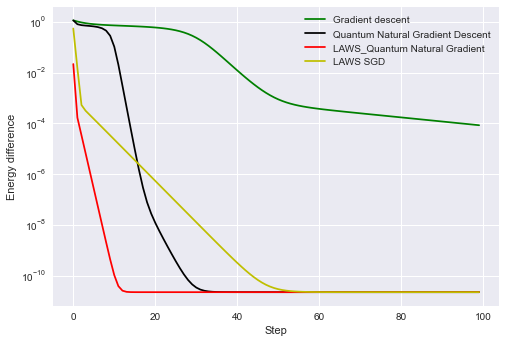

In [11]:
plt.style.use("seaborn")
plt.plot(np.array(sgd_cost) - exact_value, "g", label="Gradient descent")
plt.plot(np.array(qngd_cost) - exact_value, "k", label="Quantum Natural Gradient Descent")
plt.plot(np.array(laws_cost) - exact_value, "r", label="LAWS_Quantum Natural Gradient")
plt.plot(np.array(wssgd_cost) - exact_value, "y", label="LAWS SGD")
plt.yscale("log")
plt.ylabel("Energy difference")
plt.xlabel("Step")
plt.legend()
plt.savefig('HM_exp.png')
plt.show()

## Different Configs of Look Around Loop in Warm-start Optimizer 

In [12]:
gradient_method = "default"
#gradient_method = "ema"

opt = LAWSNG(delta= 0.01,
             lookaround_stepsize= 1.0,
             lookaround_loop=5,
             gradient_method = gradient_method,
             beta = 0.9)

params = init_params
prev_energy = cost(params)
laws_cost_loop_0 = []

for n in range(max_iterations):
    
    params, prev_energy = opt.step_and_cost(cost, params)
    
    laws_cost_loop_0.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

#     if conv <= conv_tol:
#         break


print("\nFinal convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = -0.40658335 Ha
Iteration = 20,  Energy = -1.13618907 Ha
Iteration = 40,  Energy = -1.13618945 Ha
Iteration = 60,  Energy = -1.13618945 Ha
Iteration = 80,  Energy = -1.13618945 Ha

Final convergence parameter = 0.00000000 Ha
Number of iterations =  99
Final value of the ground-state energy = -1.13618945 Ha
Accuracy with respect to the FCI energy: 0.00000000 Ha (0.00000001 kcal/mol)

Final circuit parameters = 
 [3.44829694e+00 6.28318531e+00 3.78727399e+00 3.42360201e+00
 3.72939463e-81 4.05827240e+00 2.74944154e+00 6.07345073e+00
 6.28318531e+00 2.40923412e+00 6.28318531e+00 3.32314479e+00]


In [13]:
gradient_method = "default"
#gradient_method = "ema"

opt = LAWSNG(delta= 0.01,
             lookaround_stepsize= 1.0,
             lookaround_loop=10,
             gradient_method = gradient_method,
             beta = 0.9)

params = init_params
prev_energy = cost(params)
laws_cost_loop_1 = []

for n in range(max_iterations):
    
    params, prev_energy = opt.step_and_cost(cost, params)
    
    laws_cost_loop_1.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

#     if conv <= conv_tol:
#         break


print("\nFinal convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = -0.50374562 Ha
Iteration = 20,  Energy = -1.13618945 Ha
Iteration = 40,  Energy = -1.13618945 Ha
Iteration = 60,  Energy = -1.13618945 Ha
Iteration = 80,  Energy = -1.13618945 Ha

Final convergence parameter = 0.00000000 Ha
Number of iterations =  99
Final value of the ground-state energy = -1.13618945 Ha
Accuracy with respect to the FCI energy: 0.00000000 Ha (0.00000001 kcal/mol)

Final circuit parameters = 
 [3.44829694e+000 6.28318531e+000 3.78727399e+000 3.42360201e+000
 2.71827561e-168 4.05827240e+000 2.74944154e+000 6.07345073e+000
 6.28318531e+000 2.40923412e+000 6.28318531e+000 3.32314479e+000]


In [14]:
gradient_method = "default"
#gradient_method = "ema"

opt = LAWSNG(delta= 0.01,
             lookaround_stepsize= 1.0,
             lookaround_loop=25,
             gradient_method = gradient_method,
             beta = 0.9)

params = init_params
prev_energy = cost(params)
laws_cost_loop_2 = []

for n in range(max_iterations):
    
    params, prev_energy = opt.step_and_cost(cost, params)
    
    laws_cost_loop_2.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

#     if conv <= conv_tol:
#         break


print("\nFinal convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = -1.13520825 Ha
Iteration = 20,  Energy = -1.13618945 Ha
Iteration = 40,  Energy = -1.13618945 Ha
Iteration = 60,  Energy = -1.13618945 Ha
Iteration = 80,  Energy = -1.13618945 Ha

Final convergence parameter = 0.00000000 Ha
Number of iterations =  99
Final value of the ground-state energy = -1.13618945 Ha
Accuracy with respect to the FCI energy: 0.00000000 Ha (0.00000001 kcal/mol)

Final circuit parameters = 
 [ 3.44829694e+000  6.28318531e+000  3.78727399e+000  3.42360201e+000
 -2.35490799e-281  4.05827240e+000  2.74944154e+000  6.07345073e+000
  6.28318531e+000  2.40923412e+000  6.28318531e+000  3.32314479e+000]


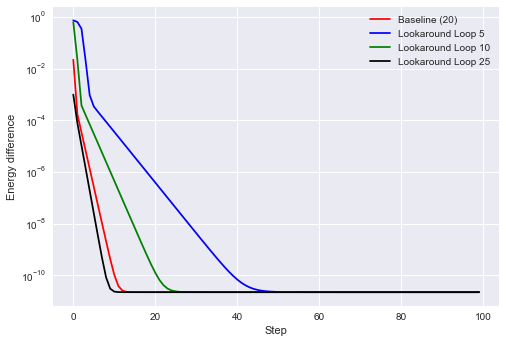

In [15]:
plt.style.use("seaborn")
plt.plot(np.array(laws_cost) - exact_value, "r", label="Baseline (20)")
plt.plot(np.array(laws_cost_loop_0) - exact_value, "b", label="Lookaround Loop 5")
plt.plot(np.array(laws_cost_loop_1) - exact_value, "g", label="Lookaround Loop 10")
plt.plot(np.array(laws_cost_loop_2) - exact_value, "k", label="Lookaround Loop 25")

plt.yscale("log")
plt.ylabel("Energy difference")
plt.xlabel("Step")
plt.legend()
plt.savefig('HM_exp_innerloop.png')
plt.show()

## Different Configs in Warm-start Optimizer (Others)

In [16]:
#gradient_method = "default"
gradient_method = "ema"

opt = LAWSNG(delta= 0.01,
             lookaround_stepsize= 1.0,
             lookaround_loop=20,
             gradient_method = gradient_method,
             beta = 0.99)

params = init_params
prev_energy = cost(params)
laws_cost_ema = []

for n in range(max_iterations):
    
    params, prev_energy = opt.step_and_cost(cost, params)
    
    laws_cost_ema.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

#     if conv <= conv_tol:
#         break


print("\nFinal convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = -1.11385106 Ha
Iteration = 20,  Energy = -1.13618945 Ha
Iteration = 40,  Energy = -1.13618945 Ha
Iteration = 60,  Energy = -1.13618945 Ha
Iteration = 80,  Energy = -1.13618945 Ha

Final convergence parameter = 0.00000000 Ha
Number of iterations =  99
Final value of the ground-state energy = -1.13618945 Ha
Accuracy with respect to the FCI energy: 0.00000000 Ha (0.00000001 kcal/mol)

Final circuit parameters = 
 [3.44829694e+000 6.28318531e+000 3.78727399e+000 3.42360201e+000
 4.94065646e-324 4.05827240e+000 2.74944154e+000 6.07345073e+000
 6.28318531e+000 2.40923412e+000 6.28318531e+000 3.32314479e+000]


In [17]:
#gradient_method = "default"
gradient_method = "ema"

opt = LAWSNG(delta= 0.01,
             lookaround_stepsize= 0.5,
             lookaround_loop=20,
             gradient_method = gradient_method,
             beta = 0.9)

params = init_params
prev_energy = cost(params)
laws_cost_ls= []

for n in range(max_iterations):
    
    params, prev_energy = opt.step_and_cost(cost, params)
    
    laws_cost_ls.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

#     if conv <= conv_tol:
#         break


print("\nFinal convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = -0.53200400 Ha
Iteration = 20,  Energy = -1.13618945 Ha
Iteration = 40,  Energy = -1.13618945 Ha
Iteration = 60,  Energy = -1.13618945 Ha
Iteration = 80,  Energy = -1.13618945 Ha

Final convergence parameter = 0.00000000 Ha
Number of iterations =  99
Final value of the ground-state energy = -1.13618945 Ha
Accuracy with respect to the FCI energy: 0.00000000 Ha (0.00000001 kcal/mol)

Final circuit parameters = 
 [3.44829694e+000 6.28318531e+000 3.78727399e+000 3.42360201e+000
 3.53628705e-147 4.05827240e+000 2.74944154e+000 6.07345073e+000
 6.28318531e+000 2.40923412e+000 6.28318531e+000 3.32314479e+000]


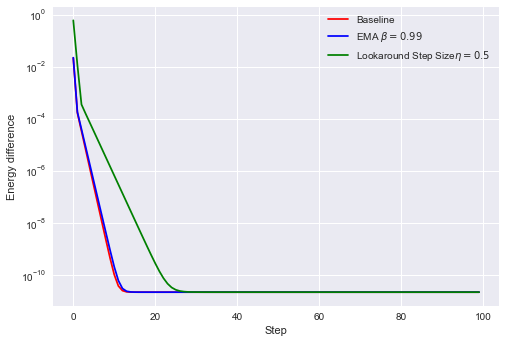

In [18]:
plt.style.use("seaborn")
plt.plot(np.array(laws_cost) - exact_value, "r", label="Baseline")
plt.plot(np.array(laws_cost_ema) - exact_value, "b", label="EMA " + r'$\beta=0.99$')
plt.plot(np.array(laws_cost_ls) - exact_value, "g", label="Lookaround Step Size" + r'$\eta=0.5$')

plt.yscale("log")
plt.ylabel("Energy difference")
plt.xlabel("Step")
plt.legend()
plt.savefig('HM_exp_others.png')
plt.show()